##### SME0202 Métodos Numéricos em Equações Diferenciais Ordinárias
## Trabalho 2 - Problemas de Valor Inicial - Pêndulo Simples e Duplo
- Cody Stefano Barham Setti - 4856322
- Ian de Holanda Cavalcanti Bezerra - 13835412

#### Bibliotecas Usadas

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipk

#### Configurando Estilo dos Gráficos

In [68]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 12

### Tarefa 1 - Pêndulo Simples

#### Solução Analítica de Referência

Temos o seguinte PVI:
$$
\begin{cases}
    q^{\prime\prime}(t) + \sin(q(t)) = 0 \\
    q(0) = q_0 \\
    q^\prime(0) = 0
\end{cases}
$$
A solução analítica deste PVI é
$$
    q(t) = 2\arcsin\left\{\sin\left(\tfrac{q_0}{2}\right)\operatorname{sn}\left[K\left({\sin\left(\tfrac{q_0}{2}\right)}^2\right)-t;{\sin\left(\tfrac{q_0}{2}\right)}^2\right]\right\},
$$
onde $\operatorname{sn}(\cdot\,;\cdot)$ denota a função elíptica de Jacobi e $K(\cdot)$ a integral elíptica completa de primeira ordem.

In [69]:
def RefSolution(q_0, t):
    """
    Solução Analítica para o pêndulo simples usando funções elípticas

    Parâmetros:
    q_0: Amplitude inicial (rad - float)
      t: Array de tempo    (s - np.array)

    Retornos:
    q: Posição angular    (rad - float)
    p: Velocidade angular (rad/s - folat)
    """
    # Variáveis auxiliares
    k_0 = np.sin(q_0/2)

    # Integral elíptica completa de primeira ordem
    K = ellipk(k_0**2)

    # Funções elípticas de Jacobi: sn, cn, dn & ph
    sn, cn, _, _ = ellipj(K - t, k_0**2)

    # Posição angular
    q = 2 * np.arcsin(k_0 * sn)

    # Velocidade angular
    dq_dt = -2 * k_0 * cn

    return q, dq_dt

Se definirmos $u_1(t) \coloneqq q(t)$ e $u_2(t) \coloneqq q'(t)$, então, podemos mudar de uma EDO de 2ª ordem para um sistema $2\times2$ de EDOs de primeira ordem, como descrito abaixo:
$$
\begin{cases}
    \begin{bmatrix}u_1(t) \\ u_2(t)\end{bmatrix}' = \begin{bmatrix}u_2(t) \\ \sin(u_1(t))\end{bmatrix} \\ \\
    \begin{bmatrix}u_1(0) \\ u_2(0)\end{bmatrix} = \begin{bmatrix}q_0 \\ 0\end{bmatrix}
\end{cases}
\qquad\text{ou, de forma mais enxuta,}\qquad
\begin{cases}
    \boldsymbol{u}'(t) = \boldsymbol{f}(\boldsymbol{u}(t)) \\
    \boldsymbol{u}(0) = \boldsymbol{\eta}
\end{cases}
$$
Note que este sistema é autônomo, isto é, $\boldsymbol{f}$ não depende diretamente de $t$.

In [70]:
def pendulum_system(u):
    """
    Representação do pêndulo simples como sistema de EDOs de 1ª ordem
    u = [q, p], onde q é a posição angular (rad) e p a velocidade angular (rad/s)
    (dtype[u] = lista contendo dois floats)
    """
    u1, u2 = u 
    du1_dt = u2 
    du2_dt = -np.sin(u1)
    return np.array([du1_dt, du2_dt])

#### Tarefa 1.1 - Implementação dos Métodos de Euler, RK4 (Clássico) e Euler Implícito

Implementação do Método de Euler Explícito

In [71]:
def euler_explicit(f, u0, t_span, h):
    t = np.arange(t_span[0], t_span[1]+h, h)
    N = len(t)
    U = np.zeros((N, len(u0)))
    U[0,:] = u0

    for n in range(N-1):
        U[n+1,:] = U[n,:] + h*f(U[n,:])
    
    return t, U

Implementação do Método Runge-Kutta de 4ª Ordem Clássico

In [72]:
def rk4(f, u0, t_span, h):
    t = np.arange(t_span[0], t_span[1]+h, h)
    N = len(t)
    U = np.zeros((N, len(u0)))
    U[0,:] = u0
    
    for n in range(N-1):
        K1 = f(U[n,:])
        K2 = f(U[n,:] + 0.5*h*K1)
        K3 = f(U[n,:] + 0.5*h*K2)
        K4 = f(U[n,:] + h*K3)
        U[n+1,:] = U[n,:] + (h/6)*(K1 + 2*K2 + 2*K3 + K4)
    
    return t, U

Implementação do Método de Euler Implícito

In [73]:
def euler_implicit(f, u0, t_span, h, tol=1e-10, max_iter=50):
    t = np.arange(t_span[0], t_span[1]+h, h)
    N = len(t)
    U = np.zeros((N, len(u0)))
    U[0,:] = u0
    
    for n in range(N-1):
        # Método de Newto para resolver: U^{n+1} = U^n + h*f(U^{n+1})
        U_guess = U[n,:] + h*f(U[n,:])  # Chute inicial utilizando 'Euler Explícito'
        
        for _ in range(max_iter):
            U1_guess, U2_guess = U_guess
            
            # Resíduo: G(U) := U - U^n - h*f(U) = 0
            G = U_guess - U[n,:] - h*f(U_guess)
            
            # Jacobiano de G:     J := dG/dU = I - h*df/dU
            # Para o pêndulo: df/dU  = [[  d/du1(u2)   ,    d/du1(u2)   ], = [[   0    , 1],
            #                           [d/du2(sin(u1)), d/du2(sin(u1)) ]]    [-cos(u1), 0]]
            J = np.array([[         1        , -h],
                          [h*np.cos(U1_guess),  1]])
            
            # Atualização de Newton
            delta = np.linalg.solve(J, -G)
            U_guess = U_guess + delta
            
            if np.linalg.norm(delta) < tol:
                break
        
        U[n+1,:] = U_guess
    
    return t, U 

#### Tarefa 1.2 - Evolução Temporal do Pêndulo Simples Segundo os Métodos Numéricos Implementados

Condições iniciais elegidas para o PVI:

In [74]:
q0 = np.pi/4  # 45º
p0 = 0.0

Domínio temporal considerado:

In [75]:
t_span = [0, 26]

Discretização da evolução temporal elegida:

In [76]:
h = 0.01

Evoluções temporais do pêndulo simples fornecidas pelos *solvers* `euler_explicit`, `rk4` e `euler_implicit`:

In [77]:
u0 = np.array([q0, p0])

t, U_euler    = euler_explicit(pendulum_system, u0, t_span, h)
t, U_rk4      =            rk4(pendulum_system, u0, t_span, h)
t, U_implicit = euler_implicit(pendulum_system, u0, t_span, h)

# Resgatar solução de referência
q_ref, p_ref = RefSolution(q0, t)

Gráficos fornecidos por cada *solver*

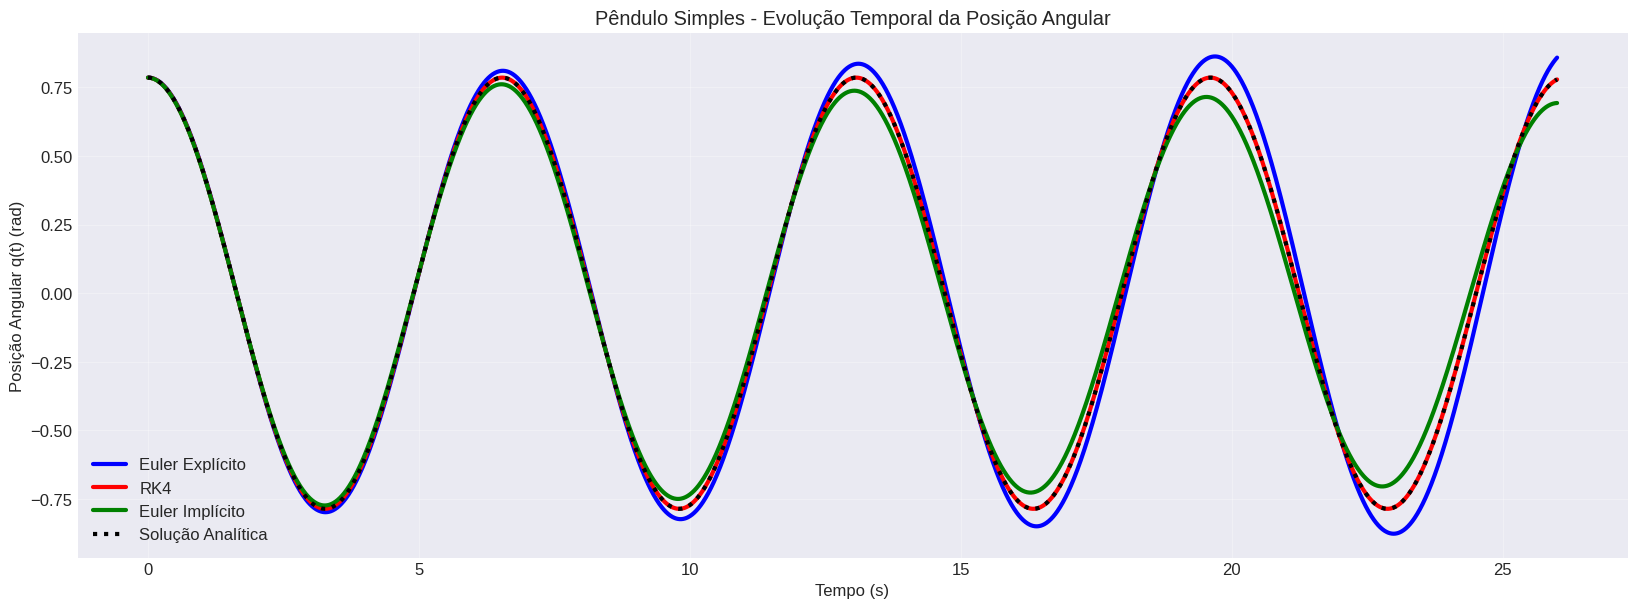

In [78]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.plot(t, U_euler[:,0]   , 'b-', label='Euler Explícito'  , linewidth=3)
plt.plot(t, U_rk4[:,0]     , 'r-', label='RK4'              , linewidth=3)
plt.plot(t, U_implicit[:,0], 'g-', label='Euler Implícito'  , linewidth=3)
plt.plot(t, q_ref          , 'k:', label='Solução Analítica', linewidth=3)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição Angular q(t) (rad)')
plt.title('Pêndulo Simples - Evolução Temporal da Posição Angular')
plt.legend()
plt.grid(True, alpha=0.3)

#### Tarefa 1.3 - Análise de Ordem de Convergência dos Métodos Numéricos Implementados

In [79]:
def empirical_convergence_order(method):
    # Diferentes tamanhos de passo (de tempo)
    h_values = np.array([0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625])

    # Tempo final observado é fixo, para uma comparação justa!
    T = 10.0
    t_span = [0, T]
    
    # Inicialização de uma 'list' para armazenar o erro correspondente a cada tamanho de passo
    errors = []

    for h in h_values:
        # Aplicar método com tamanho de passo atual
        t, U = method(pendulum_system, u0, t_span, h)

        # Resgatar solução de referência (nos mesmos pontos da solução aproximada)
        q_ref, _ = RefSolution(q0, t)

        # Erro dado pelo ponto de maior discrepância entre as soluções
        error_h = np.max(np.abs(U[:,0] - q_ref))
        errors.append(error_h)

    errors = np.array(errors)

    # Calcular ordem de convergência
    orders = []
    for i in range(len(errors)-1):
        order = np.log(errors[i]/errors[i+1]) / np.log(h_values[i]/h_values[i+1])
        orders.append(order)
        
    return h_values, errors, orders

In [80]:
h_values, err_euler   , orders_euler    = empirical_convergence_order(euler_explicit)
h_values, err_rk4     , orders_rk4      = empirical_convergence_order(rk4)
h_values, err_implicit, orders_implicit = empirical_convergence_order(euler_implicit)

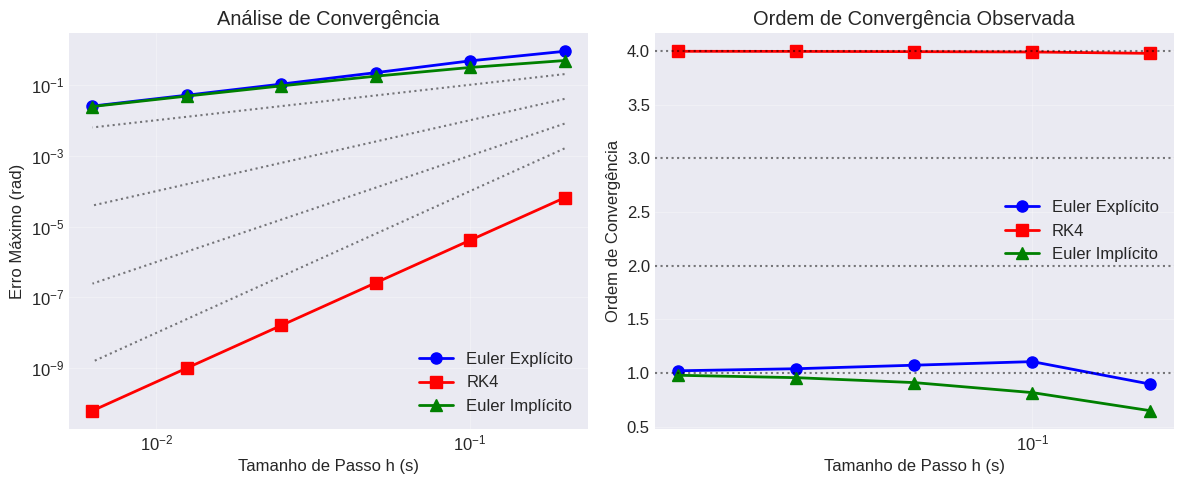

Resultados da Análise de Convergência:
Método               Ordem Média     Ordem Esperada 
----------------------------------------------------
Euler Explícito      1.03            1
RK4                  3.99            4
Euler Implícito      0.86            1


In [81]:
# Plotar convergência dos métodos
plt.figure(figsize=(12, 5))

# Erro vs Tamanho de Passo (Temporal)
plt.subplot(1, 2, 1)
plt.loglog(h_values, err_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.loglog(h_values, err_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.loglog(h_values, err_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)

# Linhas de referência
plt.loglog(h_values, h_values   , 'k:', alpha=0.5)
plt.loglog(h_values, h_values**2, 'k:', alpha=0.5)
plt.loglog(h_values, h_values**3, 'k:', alpha=0.5)
plt.loglog(h_values, h_values**4, 'k:', alpha=0.5)

plt.xlabel('Tamanho de Passo h (s)')
plt.ylabel('Erro Máximo (rad)')
plt.title('Análise de Convergência')
plt.legend()
plt.grid(True, alpha=0.3)

# Taxas de convergência
plt.subplot(1, 2, 2)
plt.plot(h_values[:-1], orders_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.plot(h_values[:-1], orders_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.plot(h_values[:-1], orders_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)
plt.axhline(y=1, color='k', linestyle=':', alpha=0.5)
plt.axhline(y=2, color='k', linestyle=':', alpha=0.5)
plt.axhline(y=3, color='k', linestyle=':', alpha=0.5)
plt.axhline(y=4, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Tamanho de Passo h (s)')
plt.ylabel('Ordem de Convergência')
plt.title('Ordem de Convergência Observada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

# Imprimir taxas de convergência
print("Resultados da Análise de Convergência:")
print("="*52)
print(f"{'Método':<20} {'Ordem Média':<15} {'Ordem Esperada':<15}")
print("-"*52)
print(f"{'Euler Explícito':<20} {np.mean(orders_euler):.2f}            {1}")
print(f"{'RK4':<20} {np.mean(orders_rk4):.2f}            {4}")
print(f"{'Euler Implícito':<20} {np.mean(orders_implicit):.2f}            {1}")

#### Tarefa 1.4 - Retrato de Fase (Velocidade Angular $\times$ Posição Angular)

Intervalo de tempo e tamanho de passo (temporal) considerados para os retratos de fase:

In [82]:
t_span_long = [0, 50]
h_phase = 0.01

Retrato de fase de cada *solver*

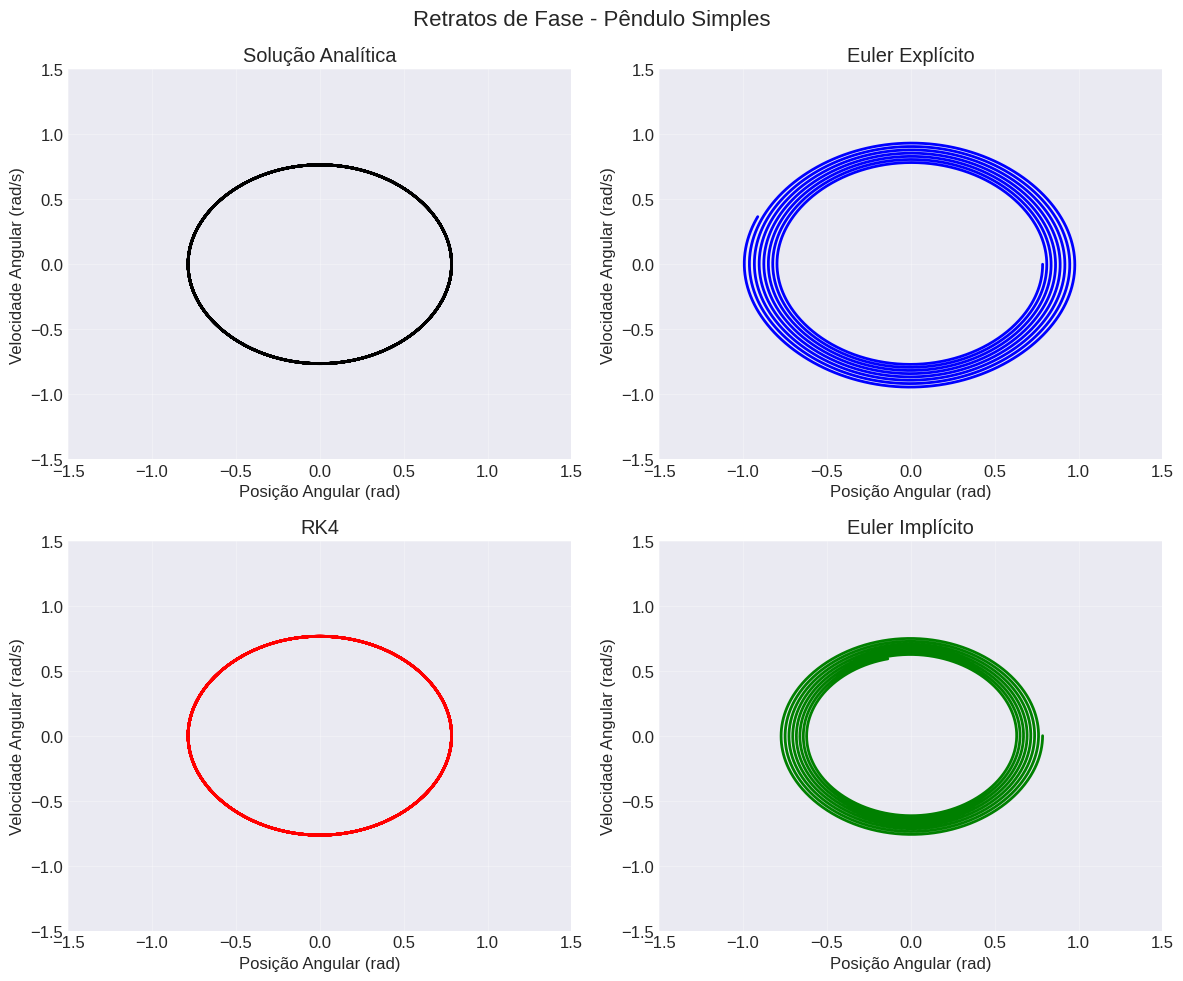

In [83]:
t_long, U_euler_long    = euler_explicit(pendulum_system, u0, t_span_long, h_phase)
t_long, U_rk4_long      =            rk4(pendulum_system, u0, t_span_long, h_phase)
t_long, U_implicit_long = euler_implicit(pendulum_system, u0, t_span_long, h_phase)

q_ref_long, p_ref_long  = RefSolution(q0, t_long)

# Criar retratos de fase
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Reference solution
axes[0, 0].plot(q_ref_long, p_ref_long, 'k-', linewidth=2)
axes[0, 0].set_xlabel('Posição Angular (rad)')
axes[0, 0].set_ylabel('Velocidade Angular (rad/s)')
axes[0, 0].set_title('Solução Analítica')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(-1.5, 1.5)
axes[0, 0].set_ylim(-1.5, 1.5)

# Euler explícito
axes[0, 1].plot(U_euler_long[:, 0], U_euler_long[:, 1], 'b-', linewidth=2)
axes[0, 1].set_xlabel('Posição Angular (rad)')
axes[0, 1].set_ylabel('Velocidade Angular (rad/s)')
axes[0, 1].set_title('Euler Explícito')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-1.5, 1.5)
axes[0, 1].set_ylim(-1.5, 1.5)

# RK4
axes[1, 0].plot(U_rk4_long[:, 0], U_rk4_long[:, 1], 'r-', linewidth=2)
axes[1, 0].set_xlabel('Posição Angular (rad)')
axes[1, 0].set_ylabel('Velocidade Angular (rad/s)')
axes[1, 0].set_title('RK4')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-1.5, 1.5)
axes[1, 0].set_ylim(-1.5, 1.5)

# Euler implícito
axes[1, 1].plot(U_implicit_long[:, 0], U_implicit_long[:, 1], 'g-', linewidth=2)
axes[1, 1].set_xlabel('Posição Angular (rad)')
axes[1, 1].set_ylabel('Velocidade Angular (rad/s)')
axes[1, 1].set_title('Euler Implícito')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(-1.5, 1.5)
axes[1, 1].set_ylim(-1.5, 1.5)

plt.suptitle('Retratos de Fase - Pêndulo Simples', fontsize=16)
plt.tight_layout()
plt.show()

Retratos de fase sobrepostos

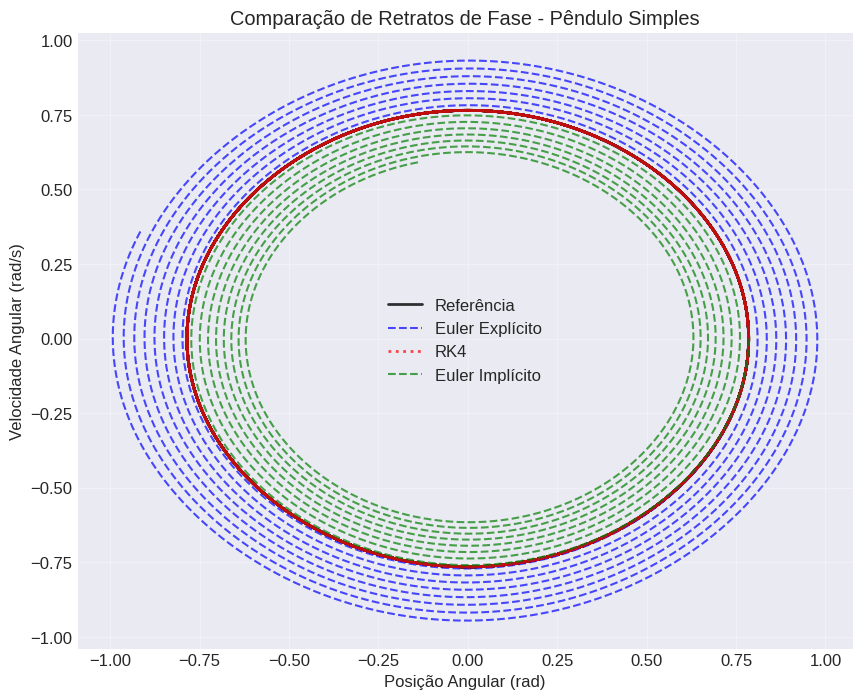

In [84]:
plt.figure(figsize=(10, 8))
plt.plot(q_ref_long           , p_ref_long           , 'k-' , label='Referência'     , linewidth=2  , alpha=0.8)
plt.plot(U_euler_long[:, 0]   , U_euler_long[:, 1]   , 'b--', label='Euler Explícito', linewidth=1.5, alpha=0.7)
plt.plot(U_rk4_long[:, 0]     , U_rk4_long[:, 1]     , 'r:' , label='RK4'            , linewidth=2  , alpha=0.7)
plt.plot(U_implicit_long[:, 0], U_implicit_long[:, 1], 'g--', label='Euler Implícito', linewidth=1.5, alpha=0.7)
plt.xlabel('Posição Angular (rad)')
plt.ylabel('Velocidade Angular (rad/s)')
plt.title('Comparação de Retratos de Fase - Pêndulo Simples')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Tarefa 2 - Pêndulo Duplo 

Se definirmos 
$$
\boldsymbol{u}(t) \coloneqq \begin{bmatrix}u_1(t) \\ u_2(t) \\ u_3(t) \\ u_4(t)\end{bmatrix} \coloneqq \begin{bmatrix}q_1(t) \\ q_2(t) \\ p_1(t) \\ p_2(t)\end{bmatrix}
$$
então, o sistema de pêndulo duplo é caracterizado pelo seguinte sistema de EDOs:

$$
    \begin{bmatrix}u_1(t) \\ u_2(t) \\ u_3(t) \\ u_4(t)\end{bmatrix}' = \begin{bmatrix}\frac{u_3-u_4\cos(u_1-u_2)}{2-\cos^2(u_1-u_2)} \\ \frac{2u_4-u_3\cos(u_1-u_2)}{2-\cos^2(u_1-u_2)} \\ -A_1+A_2-2\sin(u_1) \\ A_1-A_2-\sin(u_2)\end{bmatrix}
$$
onde $A_1 \coloneqq \frac{u_3u_4\sin(u_1-u_2)}{1+\sin^2(u_1-u_2)}$ e $A_2 \coloneqq \frac{\left[u_3^2 + 2u_4^2 - 2u_3u_4\cos(u_1-u_2)\right]\sin(u_1-u_2)\cos(u_1-u_2)}{\left[1+\sin^2(u_1-u_2)\right]^2}$. Note que este sistema, como no caso do pêndulo simples, é autônomo, isto é, $\boldsymbol{f}$ não depende diretamente de $t$.

In [85]:
def double_pendulum_system(u):
    """
    Representação do pêndulo duplo como sistema de EDOs de 1ª ordem
    u = [q1, q2, p1, p2], onde qi é a posição angular (rad) e pi o momento conjugado (kg*rad/s)
    (dtype[u] = lista contendo quatro floats)
    """
    u1, u2, u3, u4 = u 

    denomA   = 1 + np.sin(u1-u2)**2
    A1 = ( u3*u4*np.sin(u1-u2) ) / denomA
    A2 = ( (u3**2) + 2*(u4**2) - 2*u3*u4*np.cos(u1-u2) )*np.sin(u1-u2)*np.cos(u1-u2) / denomA**2

    denomU12 = 2 - np.cos(u1-u2)**2

    du1_dt = (   u3-u4*np.cos(u1-u2) ) / denomU12
    du2_dt = ( 2*u4-u3*np.cos(u1-u2) ) / denomU12
    du3_dt = -A1 + A2 - 2*np.sin(u1)
    du4_dt =  A1 - A2 -   np.sin(u2)
    return np.array([du1_dt, du2_dt, du3_dt, du4_dt])

#### Tarefa 2.1 - Evolução Temporal do Pêndulo Duplo Segundo o Método $\text{RK}4$

Aqui, é possível reutilizar o *solver* `rk4` desenvolvido na seção sobre o pêndulo simples, basta trocarmos o parâmetro `f` de `pendulum_system` para o argumento `double_pendulum_system`, assim como o parâmetro `u0` de `[q0, 0]` para o argumento de dimensão condizente `[q1_0, q2_0, p1_0, p2_0]`. Portanto, prossigamos à próxima tarefa, eleger condições iniciais para o o pêndulo duplo e gerar gráficos múltiplos gráficos para visualização de sua evolução temporal

#### Tarefa 2.2 - Visualização da Evolução Temporal do Pêndulo Duplo

Condições iniciais elegidas para o PVI:

In [86]:
q1_0 = 2*np.pi/3  # 120º
q2_0 =   np.pi/4  # 45º
p1_0 = 0.0
p2_0 = 0.0

##### Tarefa 2.2.(a) - Intervalo de Tempo Razoável
Domínio temporal considerado:

In [87]:
t_span_dp = [0, 150]

Discretização da evolução temporal elegida:

In [88]:
h_dp = 0.005

Evolução temporal do pêndulo duplo fornecida pelo *solver* `rk4`:

In [89]:
u0_dp = np.array([q1_0, q2_0, p1_0, p2_0])
# Obs.: u0 != np.zeros(4), logo, o pêndulo duplo inicia sua evolução fora do equilíbrio, conforme pedido

t_dp, U_dp = rk4(double_pendulum_system, u0_dp, t_span_dp, h_dp)

##### Tarefa 2.2.(b) - Conversão para Coordenadas Cartesianas

In [90]:
def convert_to_cartesian(q1, q2):
    x1 = np.sin(q1)
    y1 = -np.cos(q1)
    X1 = (x1, y1)

    x2 = x1 + np.sin(q2)
    y2 = y1-np.cos(q2)
    X2 = (x2, y2)

    return X1, X2

In [91]:
q1 = U_dp[:,0]
q2 = U_dp[:,1]

_, X2 = convert_to_cartesian(q1, q2)
x2 = X2[0]
y2 = X2[1]

##### Tarefa 2.2.(c) - Trajetória de $\boldsymbol{x}_2(t)$ no Plano Cartesiano

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


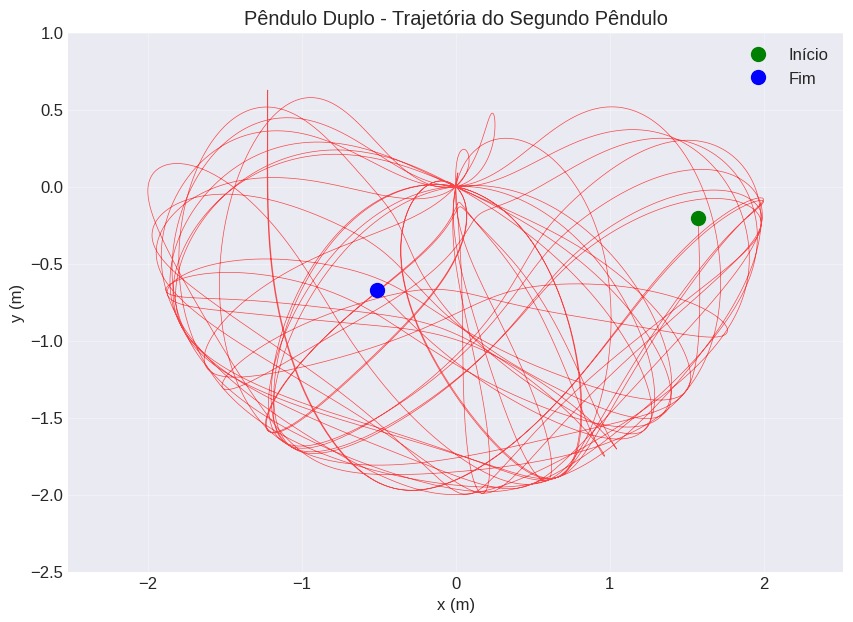

In [92]:
plt.figure(figsize=(10, 7))
plt.plot(x2, y2, 'r-', linewidth=0.5, alpha=0.7)
plt.plot(x2[0] , y2[0] , 'go', markersize=10, label='Início')  # posição inicial
plt.plot(x2[-1], y2[-1], 'bo', markersize=10, label='Fim')     # posição final
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Pêndulo Duplo - Trajetória do Segundo Pêndulo')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-2, 2)
plt.ylim(-2.5, 1)
plt.show()

#### Tarefa 2.3 - Movimento Caótico do Pêndulo Duplo

##### Tarefa 2.3.(a) - Comportamento do Pêndulo Duplo: Proximidade do Equilíbrio $\times$ Longe do Equilíbrio (Caos)

Condições iniciais elegidas para o PVI nas proximidades do equilíbrio:

In [93]:
q1_0 = 0.1
q2_0 = 0.2
p1_0 = 0.0
p2_0 = 0.0

Evolução temporal do pêndulo duplo fornecida pelo *solver* `rk4`:

In [94]:
u0_eq = np.array([q1_0, q2_0, p1_0, p2_0])

t_eq, U_eq = rk4(double_pendulum_system, u0_eq, t_span_dp, h_dp)

q1_eq = U_eq[:,0]
q2_eq = U_eq[:,1]

_, X2_eq = convert_to_cartesian(q1_eq, q2_eq)
x2_eq = X2_eq[0]
y2_eq = X2_eq[1]

Comparação das trajetórias de $\boldsymbol{x}_2(t)$ nas duas configurações

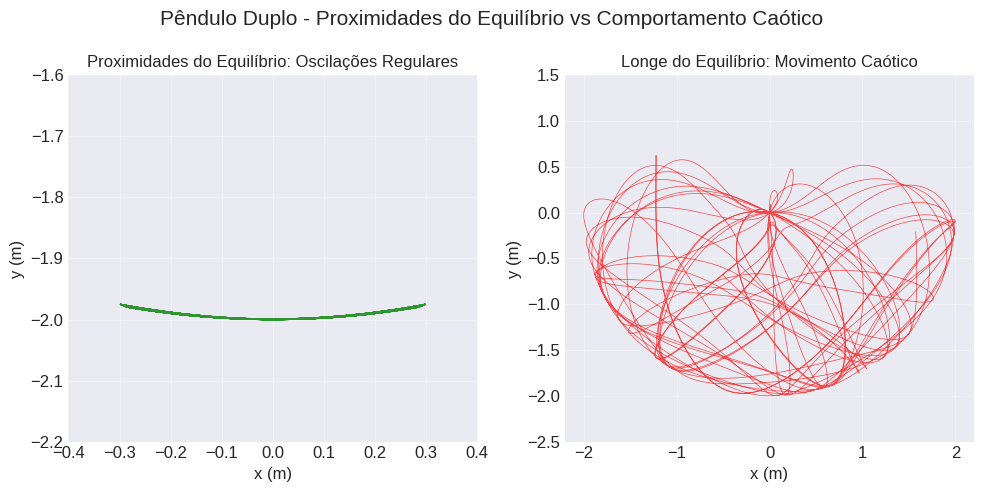

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Trajetória nas Proximidades do Equilíbrio
axes[0].plot(x2_eq, y2_eq, 'g-', linewidth=1, alpha=0.8)
axes[0].set_xlabel('x (m)')
axes[0].set_ylabel('y (m)')
axes[0].set_title('Proximidades do Equilíbrio: Oscilações Regulares', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.4, 0.4)
axes[0].set_ylim(-2.2, -1.6)

# Trajetória Original (Caótica)
axes[1].plot(x2, y2, 'r-', linewidth=0.5, alpha=0.7)
axes[1].set_xlabel('x (m)')
axes[1].set_ylabel('y (m)')
axes[1].set_title('Longe do Equilíbrio: Movimento Caótico', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-2.2, 2.2)
axes[1].set_ylim(-2.5, 1.5)

plt.suptitle('Pêndulo Duplo - Proximidades do Equilíbrio vs Comportamento Caótico', fontsize=15)
plt.tight_layout()
plt.show()

**Note:** nas proximidades do equilíbrio, o pêndulo duplo exibe um movimento previsível, quasi-periódico. Entretanto, para ângulos inicias mais afastados do equilíbrio, a situação é oposta, o movimento é caótico e imprevisível, nada periódico.

##### Tarefa 2.3.(b) - Efeito de Diferenças Infinitesimais nas Condições Iniciais Sobre a Evolução Temporal do Pêndulo Duplo

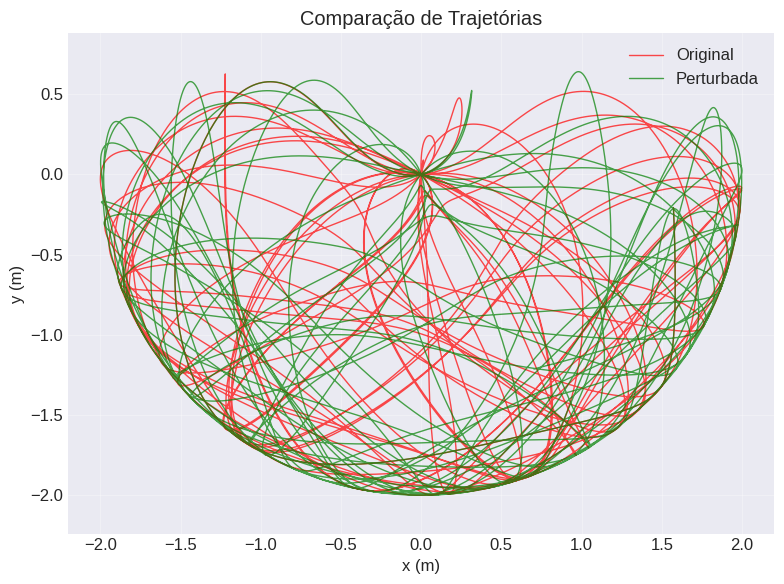

In [96]:
# Condições iniciais originais
u0_original = u0_dp

# Condições iniciais perturbadas (+0.01 rad à u1)
perturbation = np.zeros(4)
perturbation[0] = 0.001
u0_perturbed = u0_original + perturbation

# Resolução de ambos problemas
t, U_orig = rk4(double_pendulum_system, u0_original , t_span_dp, h_dp)
t, U_pert = rk4(double_pendulum_system, u0_perturbed, t_span_dp, h_dp)

# Converter para coordenadas cartesianas
X1_orig, X2_orig = convert_to_cartesian(U_orig[:,0], U_orig[:,1])
x1_orig, y1_orig = X1_orig[0], X1_orig[1]
x2_orig, y2_orig = X2_orig[0], X2_orig[1]

X1_pert, X2_pert = convert_to_cartesian(U_pert[:,0], U_pert[:,1])
x1_pert, y1_pert = X1_pert[0], X1_pert[1]
x2_pert, y2_pert = X2_pert[0], X2_pert[1]

# Gráficos
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x2_orig, y2_orig, 'r-', linewidth=1, alpha=0.7, label='Original')
ax.plot(x2_pert, y2_pert, 'g-', linewidth=1, alpha=0.7, label=f'Perturbada')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f'Comparação de Trajetórias')
ax.axis('equal')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Note:** Por mais que a pertubação sobre o problema seja minúscula, após tempo suficiente, sua trajetória torna-se irreconhecível quando comparada à do problema original. Este grau de sensibilidade às condições iniciais é uma característica clássica do comportamento caótico.